<a href="https://colab.research.google.com/github/myutman/DUL/blob/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.utils.data
from torch.optim import SGD, Adam
from torch.nn import Linear, Sigmoid, Dropout, Softmax, Sequential, ReLU
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Задание 1

In [0]:
import numpy as np
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
def p(theta, x):
    return torch.exp(theta[x]) / torch.sum(torch.exp(theta))

def J(output):
    return -torch.sum(torch.log(output))

In [0]:
theta = torch.zeros(100, requires_grad=True)
sgd = SGD([theta], lr=0.03)

num_epochs = 20
losses = []
sample = sample_data()
size_train = int(len(sample) * 0.8)
size_test = len(sample) - size_train
train, test = torch.utils.data.random_split(sample, (size_train, size_test))

x_train = torch.tensor(train, dtype=torch.long)
x_test = torch.tensor(test, dtype=torch.long)
dataset = torch.utils.data.DataLoader(x_train, batch_size=1000, shuffle=True)
train_losses = []
test_losses = []
for i in range(num_epochs):
    for x1 in dataset:
        sgd.zero_grad()
        output = p(theta, x1)
        loss = J(output)
        losses.append(float(loss))
        loss.backward()
        sgd.step()
    train_losses.append(float(J(p(theta, x_train)).double()) / size_train)
    test_losses.append(float(J(p(theta, x_test)).double()) / size_test)

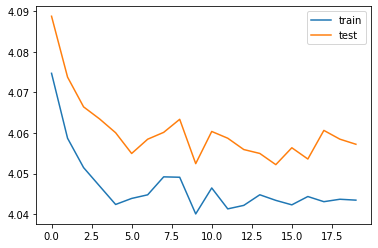

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

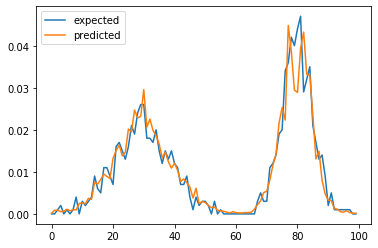

In [0]:
predicted = p(theta, range(100)).tolist()
expected = np.zeros(100)
for x in sample[:1000]:
    expected[x] += 1
expected /= 1000
expected = list(expected)

plt.plot(range(100), expected)
plt.plot(range(100), predicted)
plt.legend(['expected', 'predicted'])

# Задание 2
## 2.1

In [0]:
dist = np.load('/content/gdrive/My Drive/DUL/distribution.npy')

In [0]:
def gen_pair():
    x1 = np.random.choice(200, p=np.sum(dist, axis=1))
    x2 = np.random.choice(200, p=dist[x1] / np.sum(dist[x1]))
    return (x1, x2)

In [0]:
sample = np.array([gen_pair() for i in range(100000)])

In [0]:
size_train = int(len(sample) * 0.8)
size_test = len(sample) - size_train
train, test = torch.utils.data.random_split(sample, (size_train, size_test))

In [0]:
x_train = torch.tensor(train)
x_test = torch.tensor(test)
dataset = torch.utils.data.DataLoader(x_train, batch_size=200, shuffle=True)

In [0]:
def p(theta, x):
    return torch.exp(theta[x]) / torch.sum(torch.exp(theta))

def J(output):
    return -torch.mean(torch.log(output))

In [0]:
class MLP(nn.Module):
    def __init__(self, nin, nout, n_hidden):
        super(MLP, self).__init__()
        self.layers = []
        self.layers.extend([
            Linear(nin, 40),
            Sigmoid(),
            Dropout(0.5)
        ])
        for i in range(1, n_hidden - 1):
            self.layers.extend([
                Linear(40, 40),
                Sigmoid(),
                Dropout(0.5)
            ])
        self.layers.extend([
            Linear(40, nout),
            Softmax(dim=-1)
        ])
        torch.nn.init.normal_(self.layers[0].weight)
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)
        
class LikelihoodModel(nn.Module):
    def __init__(self, n_hidden):
        super(LikelihoodModel, self).__init__()
        self.theta = nn.Parameter(torch.zeros(200))
        self.mlp = MLP(200, 200, n_hidden)
        
    def forward(self, batch):
        x1 = batch[:,0]
        x2 = batch[:,1]
        onehots = one_hot(x1, 200).float()
        px1 = p(self.theta, x1)
        px2 = self.mlp(onehots)[range(len(batch)), x2]
        output = px1 * px2
        return J(output)

In [0]:
num_epochs = 150

model = LikelihoodModel(7)
sgd = Adam(model.parameters())
#sgd = SGD(model.parameters(), lr=0.03)

train_losses = []
test_losses = []
for i in range(num_epochs):
    avg_loss = 0
    for batch in dataset:
        sgd.zero_grad()
        loss = model(batch)
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(x_train)
    train_losses.append(avg_loss)
    test_losses.append(float(model(x_test).double()))

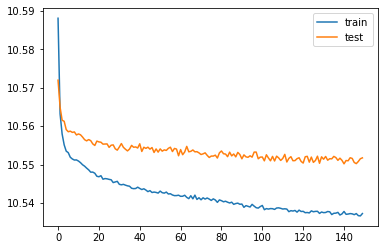

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

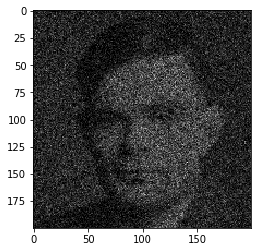

In [0]:
cnt = np.zeros((200, 200))
for x, y in sample:
    cnt[x, y] += 1

cnt /= len(sample)
plt.imshow(cnt, cmap='gray')

In [0]:
px1 = p(model.theta, range(200)).tolist()
predicted = []
for i in range(200):
    predicted.append((model.mlp(one_hot(torch.tensor([i]), 200).float())[0] * px1[i]).tolist())

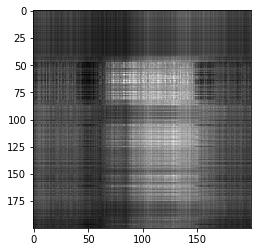

In [0]:
plt.imshow(predicted, cmap='gray')

## 2.2

In [0]:
class MaskedLayer(nn.Linear):
    def __init__(self, m_in, m_out):
        super(MaskedLayer, self).__init__(len(m_in), len(m_out))
        a = m_in.reshape((1, len(m_in)))
        b = m_out.reshape((len(m_out), 1))
        self.mask = (a <= b).float()
    
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)
    
class MADE(nn.Module):
    def __init__(self, nin, n_blocks, n_hidden):
        super(MADE, self).__init__()
        self.nin = nin
        self.n_blocks = n_blocks
        start_m = torch.tensor(np.hstack([[i] * nin for i in range(n_blocks)]))
        m1 = start_m
        m2 = torch.randint(int(m1.min().long()), n_blocks - 1, (100,))
        self.layers = [
            MaskedLayer(m1, m2),
            Sigmoid(),
            #Dropout(0.2)
        ]
        for i in range(1, n_hidden - 1):
            m1 = m2
            m2 = torch.randint(int(m1.min().long()), n_blocks - 1, (100,))
            self.layers.extend([
                MaskedLayer(m1, m2),
                Sigmoid(),
                #Dropout(0.2)
            ])
        m1 = m2
        m2 = start_m
        self.layers.append(MaskedLayer(m1, m2))
        torch.nn.init.normal_(self.layers[0].weight)
        self.seq = nn.Sequential(*self.layers)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        z = self.seq(x)
        z = z.reshape((*x.shape[:-1], self.n_blocks, self.nin))
        ans = self.softmax(z).transpose(0, -2)
        #print(ans.shape)
        return ans

class MADELikelihoodModel(nn.Module):
    def __init__(self, n_hidden):
        super(MADELikelihoodModel, self).__init__()
        self.made = MADE(200, 2, n_hidden)
    
    def forward(self, batch):
        #print(batch.shape)
        x1 = batch[:,0]
        x2 = batch[:,1]
        x = one_hot(batch, 200).reshape(-1, 400)
        #print(x.shape)
        px1, px2 = self.made(x.float())
        #print(px1.shape)
        #print(px2.shape)
        #print(len(batch))
        #print(x1, x2)
        ox1 = px1[torch.arange(len(batch)), x1]
        ox2 = px2[torch.arange(len(batch)), x2]
        output = ox1 * ox2
        return J(output)

In [0]:
#sgd = SGD([theta, *mlp.parameters()], lr=0.03)
num_epochs = 150

model = MADELikelihoodModel(5)
sgd = Adam([*model.parameters()])

train_losses = []
test_losses = []
for i in range(num_epochs):
    avg_loss = 0
    for batch in dataset:
        sgd.zero_grad()
        loss = model(batch)
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(x_train)
    train_losses.append(avg_loss)
    test_losses.append(float(model(x_test).double()))

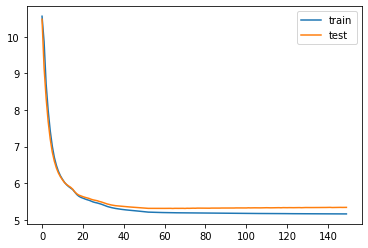

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

In [0]:
#df = pd.DataFrame()
#df['loss'] = train_losses + test_losses
#df['data'] = ['train'] * num_epochs + ['test'] * num_epochs
#df['iter'] = list(range(num_epochs)) + list(range(num_epochs))
#px.line(df, x='iter', y='loss', color='data')

In [0]:
predicted = []
for i in range(200):
    predicted.append([])
    for j in range(200):
        px1, px2 = model.made(one_hot(torch.tensor([i, j]), 200).float().reshape(-1, 400))
        #print(px1, px2)
        predicted[i].append(float((px1[0][i] * px2[0][j]).float()))

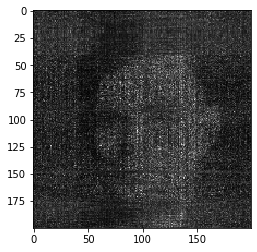

In [0]:
plt.imshow(predicted, cmap='gray')

# Задание 3
## 3.1

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, size, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.mask = torch.tensor(
            [[[[1] * kernel_size for _ in range(kernel_size // 2)] + 
                [[1] * (kernel_size // 2) + [0] * ((kernel_size + 1) // 2)] +
                [[0] * kernel_size for _ in range(kernel_size // 2)]
              for _ in range(out_channels)]
             for _ in range(in_channels)]
        )
            
        
    def forward(self, x):
        self.weights *= self.mask
        super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, n_layers):
        super(PixelCNN, self).__init__()